In [1]:
pip install wordcloud matplotlib pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Fake News Detector

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Read datasets

In [3]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [4]:
fake.shape

(23481, 4)

In [5]:
true.shape

(21417, 4)

data cleaning and preparation

In [6]:
fake['target'] = 'fake'
true['target'] = 'true'

In [7]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
data.head()

,title,text,subject,date,target
0,House intelligence panel leaders split over se...,WASHINGTON (Reuters) - The partisan divide ove...,politicsNews,"March 24, 2017",true
1,New Senate Obamacare repeal bill due Monday: s...,WASHINGTON (Reuters) - A new Republican bill t...,politicsNews,"September 7, 2017",true
2,OUCH! BERNIE SANDERS Responds To Hillary’s Cri...,WFB- The former Democratic presidential candid...,politics,"Sep 10, 2017",fake
3,THE VIEW’S Whoopi Goldberg To Co-Host: “This I...,https://youtu.be/RTuxvWjH3a4,politics,"Dec 1, 2016",fake
4,"Trump’s Biggest, Most Pansy-A** Apologist Now...",Very few of Donald Trump s fans are more blind...,News,"August 3, 2016",fake


In [10]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,House intelligence panel leaders split over se...,WASHINGTON (Reuters) - The partisan divide ove...,politicsNews,true
1,New Senate Obamacare repeal bill due Monday: s...,WASHINGTON (Reuters) - A new Republican bill t...,politicsNews,true
2,OUCH! BERNIE SANDERS Responds To Hillary’s Cri...,WFB- The former Democratic presidential candid...,politics,fake
3,THE VIEW’S Whoopi Goldberg To Co-Host: “This I...,https://youtu.be/RTuxvWjH3a4,politics,fake
4,"Trump’s Biggest, Most Pansy-A** Apologist Now...",Very few of Donald Trump s fans are more blind...,News,fake


In [11]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - The partisan divide ove...,politicsNews,true
1,WASHINGTON (Reuters) - A new Republican bill t...,politicsNews,true
2,WFB- The former Democratic presidential candid...,politics,fake
3,https://youtu.be/RTuxvWjH3a4,politics,fake
4,Very few of Donald Trump s fans are more blind...,News,fake


In [12]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - the partisan divide ove...,politicsNews,true
1,washington (reuters) - a new republican bill t...,politicsNews,true
2,wfb- the former democratic presidential candid...,politics,fake
3,https://youtu.be/rtuxvwjh3a4,politics,fake
4,very few of donald trump s fans are more blind...,News,fake


In [13]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,washington reuters the partisan divide over t...,politicsNews,true
1,washington reuters a new republican bill to r...,politicsNews,true
2,wfb the former democratic presidential candida...,politics,fake
3,httpsyoutubertuxvwjh3a4,politics,fake
4,very few of donald trump s fans are more blind...,News,fake


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bandl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data.head()

,text,subject,target
0,washington reuters partisan divide house intel...,politicsNews,true
1,washington reuters new republican bill replace...,politicsNews,true
2,wfb former democratic presidential candidate a...,politics,fake
3,httpsyoutubertuxvwjh3a4,politics,fake
4,donald trump fans blindly loyal former house s...,News,fake


Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


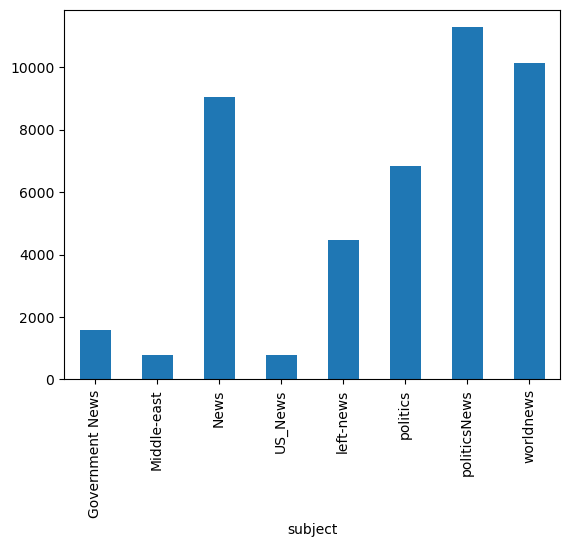

In [17]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


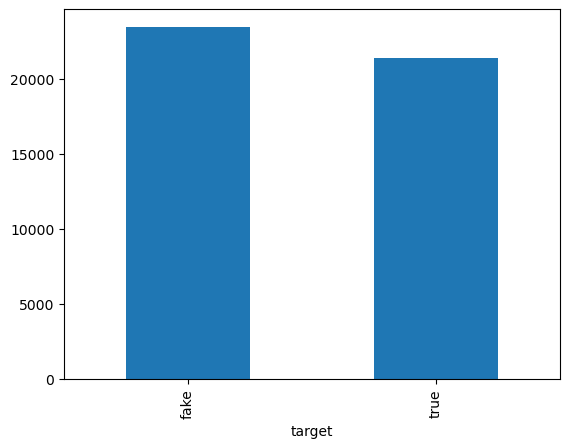

In [18]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

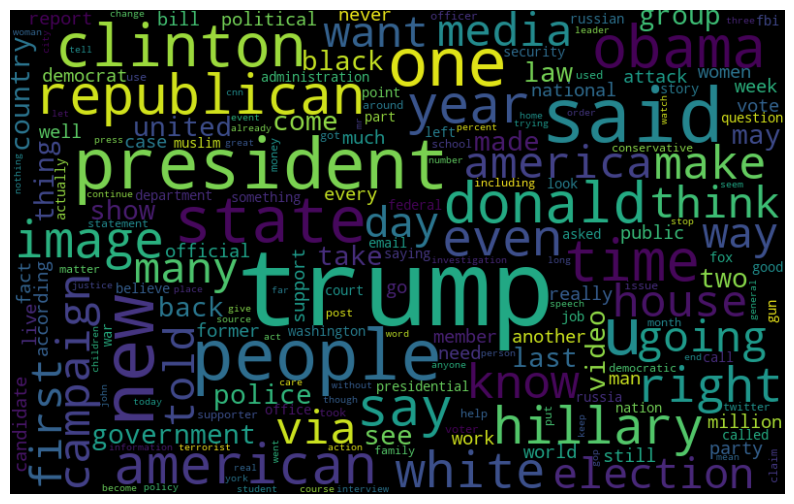

In [19]:
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

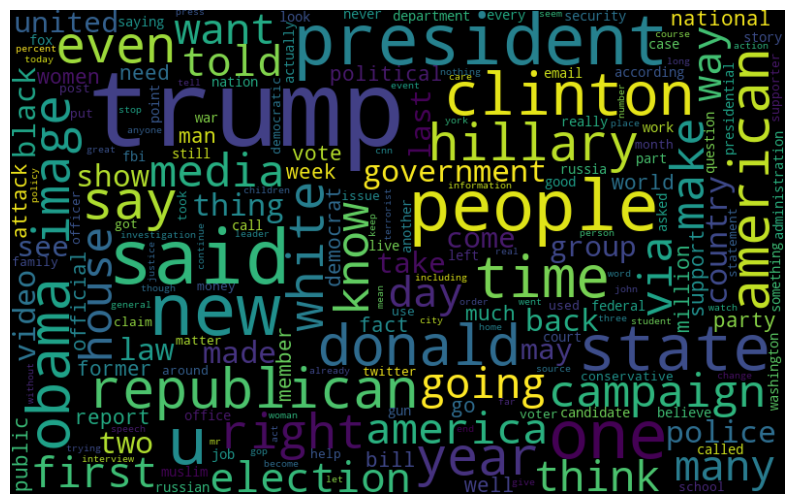

In [20]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

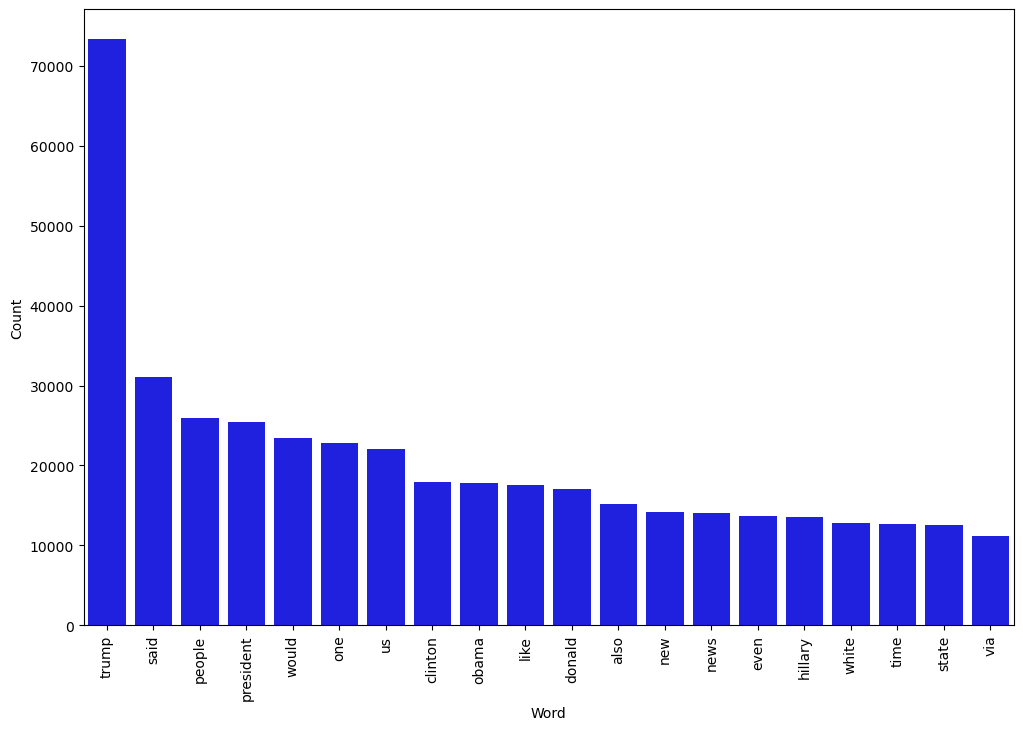

In [22]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

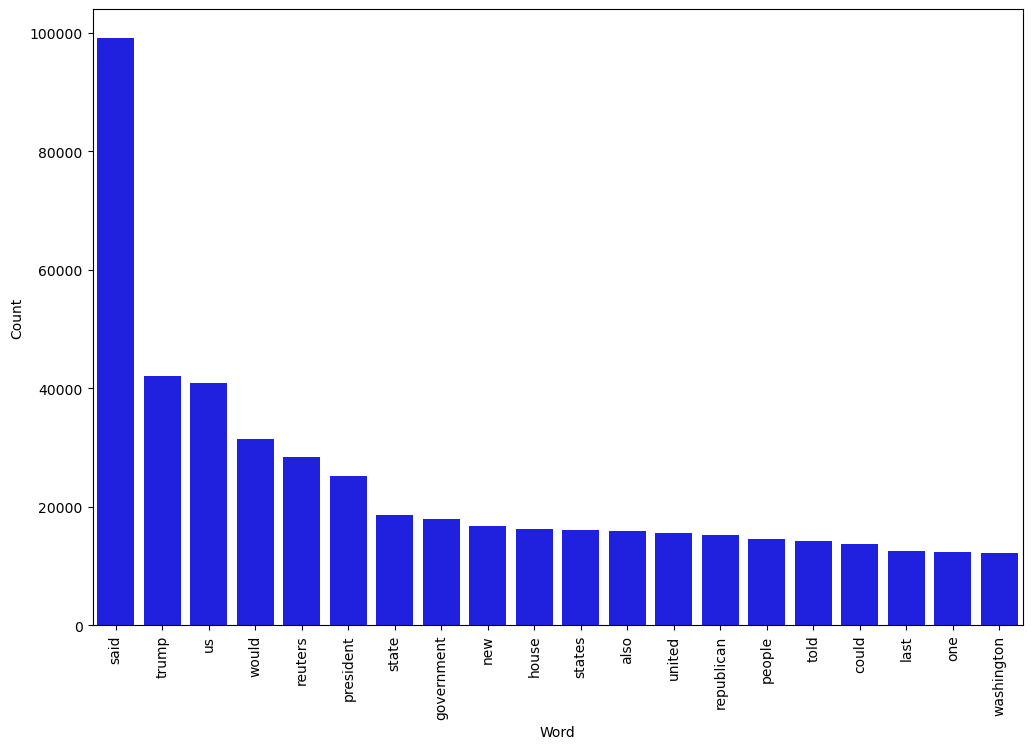

In [23]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

Modeling

In [24]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Peparing the data


In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Naive Bayes

In [26]:
dct = dict()

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


# Create the Naive Bayes classifier
NB_classifier = MultinomialNB()

# Build the pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),        # Text vectorization
    ('tfidf', TfidfTransformer()),      # TF-IDF transformation
    ('model', NB_classifier)            # Naive Bayes classifier
])

# Fit the model
model = pipe.fit(X_train, y_train)

# Make predictions
prediction = model.predict(X_test)

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.19%


Confusion matrix, without normalization


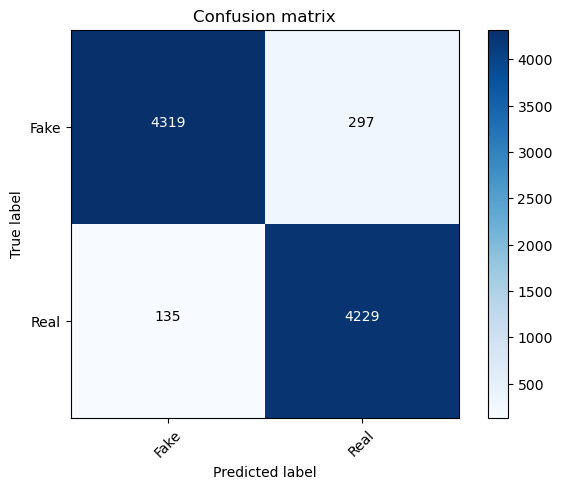

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Logistic regression

In [28]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.88%


Confusion matrix, without normalization


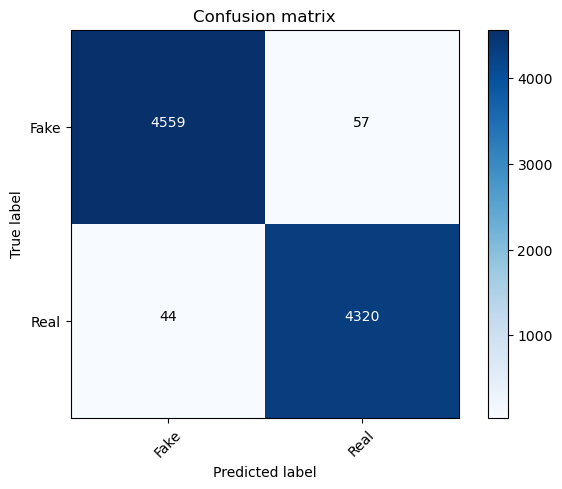

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.58%


Confusion matrix, without normalization


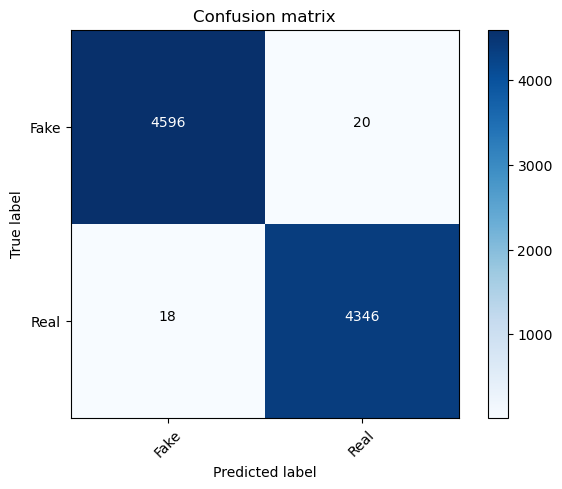

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.89%


Confusion matrix, without normalization


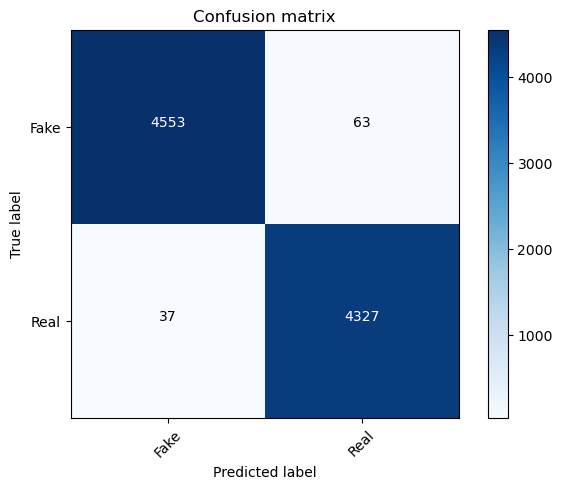

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

SVM

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])